In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import helper
import seaborn as sns

from scipy import cluster,stats
from dtaidistance import dtw,clustering

In [312]:
def hist_time(df_r,title):
   

    h_r = pd.DataFrame()
    h_range = (0,df_r.max().max())
    h_bin = 300

    for ind,col in df_r.iteritems():

        h_r[ind] = np.histogram(col,bins=h_bin,range=h_range)[0]

    h_r = h_r.sort_index(ascending=False)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(h_r)
    plt.title("Histogram over time: "+title)
    plt.xlabel("Year")
    plt.ylabel("Diversity")
    plt.yticks(np.arange(0,h_bin,h_bin/10) , np.arange(h_range[1],h_range[0],-(h_range[1]-h_range[0])/10).round(1))
    plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
    plt.show()

In [290]:
df_prod = pd.read_pickle("../data/df_prod.pkl")
df_prod = df_prod[df_prod["Unit"]=="tonnes"]
df_prod.head()

,Area,Item,Element,Unit,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
2,Afghanistan,"Almonds, with shell",Production,tonnes,9000.0,9000.0,9000.0,9000.0,9000.0,9000.0,...,31481.0,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0
5,Afghanistan,"Anise, badian, fennel, coriander",Production,tonnes,1556.0,1941.0,2000.0,4200.0,2500.0,7100.0,...,17000.0,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0
8,Afghanistan,Apples,Production,tonnes,17000.0,17500.0,19669.0,23341.0,27727.0,32386.0,...,59500.0,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0
11,Afghanistan,Apricots,Production,tonnes,37000.0,37665.0,37500.0,39368.0,40131.0,40990.0,...,58000.0,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0
14,Afghanistan,Barley,Production,tonnes,250000.0,230000.0,200000.0,220000.0,250000.0,240000.0,...,370000.0,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0


# Diversity of Producers
For the production of each item, the production diversity is calculated for each year. 
The diversity indicates how many countries produce each item, and how well distributed the production is accorss the countries.

Observing how the diversity changes over the years can help highlight items with interesting changes in production paterns.

To obtain diversity values, "Hill number" or "Effective number of species" (with q=1) is used. This is equivalent to the exponential Shannon entropy.

To select interesting changes in diversity over time, the min-max of each diveristy time-series is used.

In [291]:
#Select cutoffs to test
#The total quantity (sum accross year) is calculated
#Cutoff removes any total_quantity that is smaller than the max total_quanity for each item
cutoff_n = 11
cutoff_l = 0
cutoff_u = 0.4
cutoffs = np.linspace(cutoff_l,cutoff_u,cutoff_n)

#Initialize dataframes
dfdiv_list = list()
dfent_list = list()
df_mm = pd.DataFrame()
df_pos_l = pd.DataFrame()


#Compute diversity for each cutoff, for each item, for each year
for i in range(cutoff_n):
    cutoff = cutoffs[i]
    
    #Intialize diversity and entropy dataframe
    dfdiv=pd.DataFrame()
    dfent=pd.DataFrame()
    
    for item in df_prod.Item.unique():
        
        #Select item
        df_t = df_prod[df_prod["Item"]==item] 
        
        #Filter by cutoff
        filt = df_t.loc[:,"Y1993":].sum(axis=1)>(max(df_t.loc[:,"Y1993":].sum(axis=1))*cutoff) 
        df_t = df_t[filt]
        df_t = df_t.loc[:,"Y1993":] #Select only number values

        divsr = []
        entsr = []
        
        #For each year
        for col in df_t:
        
            #Calculate diversity values
            pv = df_t[col]/df_t[col].values.sum()
            ent = pv*np.log2(pv)*-1
            div = np.exp(ent)
            
            #Store diversity and entropy values in list
            if div.sum()>0:
                divsr.append(div.sum())
            else:
                divsr.append(np.NaN)
                
            if ent.sum()>0:
                entsr.append(ent.sum())
            else:
                entsr.append(np.NaN)
                
        #Store list of divropy values in dataframe
        dfdiv[item] = divsr
        dfent[item] = entsr
    
    #Transpose dataframe for viewing purposes
    dfdiv = dfdiv.transpose()
    dfent = dfent.transpose()
    
    #Store dataframe for each cutoff in list
    dfdiv_list.append(dfdiv)
    dfent_list.append(dfent)
    
    #Caluclate order (position of min_max) for later selection
    df_pos = dfdiv.idxmax(axis=1)-dfdiv.idxmin(axis=1)
    df_pos_l[str(i)] = df_pos/np.abs(df_pos)

    #Calculate min max difference for later selection
    df_mm[str(i)] = dfdiv.max(axis=1)-dfdiv.min(axis=1)



/Users/ENVasquez/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


A cutoff is used to remove production instances that do not contribute much to the total trade quantity of each specific item. Using a cutoff helps highlight the effect of large productors.

How the cutoff will affects an item will depend on its production distributions. To better undertand this, the mean diveristy (accross all years) is used for each item given a specific cutoff.


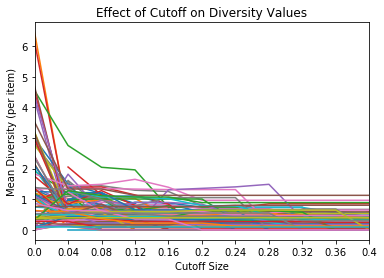

In [292]:
#Plot effect of cutoff on min_max value for each item (diversity)
df_mm.transpose().plot(legend=False)
plt.xticks(range(cutoff_n),cutoffs.round(2))
plt.xlabel("Cutoff Size")
plt.ylabel("Mean Diversity (per item)")
plt.title("Effect of Cutoff on Diversity Values")
plt.show()


Two type of behaviours are observed:
- Mean diversity sharply drops: diversity drops due to reduction in number of producers. This occurs with items who have many producers (small quanities), but one major producer. When the cutoff increases (to 0.04), all the minor producers are removed from the data, sharply dropping the diveristy.
- Mean diversity increases: diversity increases due to loss of homogenous producers. Some items have an increased mean diveristy for cutoff 0.08. Producers with similar low production quantitites are removed causing the population to be less homogenous. This effect is more significant than the loss of number of producers for this type of distribution. This range is of interest.

Next, the min_max values (for cutoff 0.08) are used to select items who have had a large change in entropy throuhgout the time period. 

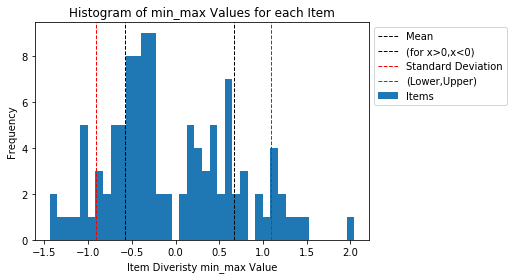

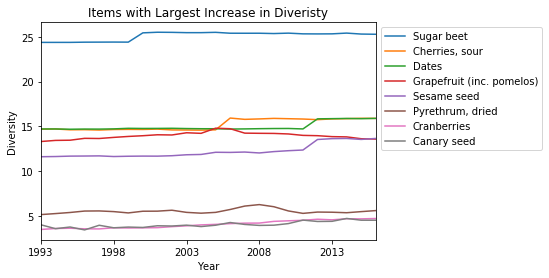

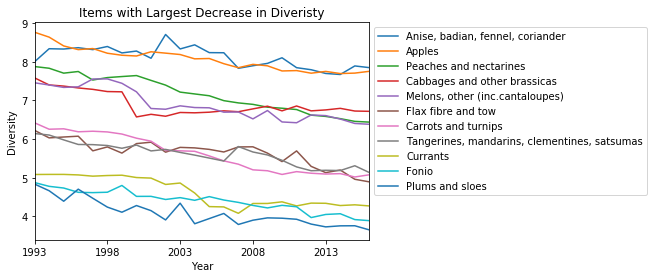

In [293]:
#Select specific cutoff to plot
cutoff = 0.08
ind_df = [i for i, x in enumerate(cutoffs==cutoff) if x][0]

#Select dataframes to plot
df_mv = df_mm[str(ind_df)].copy()
df_pos = df_pos_l[str(ind_df)]
dfdiv = dfdiv_list[ind_df]


#Generate histogram of min_max values
df_mv = (df_mv*df_pos)
df_mv.plot.hist(bins=40)
plt.xlabel("Item Diveristy min_max Value")


#Plot means for positive and negative min_max
plt.axvline(df_mv[df_mv<0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(df_mv[df_mv>0].mean(), color='k', linestyle='dashed', linewidth=1)

#Identify item selection thresholds (1 std) for largest and smallest min_max
thresh_u = df_mv[df_mv>0].mean()+df_mv[df_mv>0].std()
thresh_l = df_mv[df_mv<0].mean()-df_mv[df_mv<0].std()
#Plot these thresholds on the histogram
plt.axvline(thresh_u, color='r', linestyle='dashed', linewidth=1)
plt.axvline(thresh_l, color='r', linestyle='dashed', linewidth=1)
plt.legend(["Mean","(for x>0,x<0)","Standard Deviation","(Lower,Upper)","Items"], bbox_to_anchor=(1, 1))
plt.title("Histogram of min_max Values for each Item")
plt.show()

#Generate diversity plots for selected min_max items
df_u = dfdiv.loc[df_mv[(df_mv>thresh_u)].index.values,:]
df_u = df_u.assign(m=df_u.mean(axis=1)).sort_values('m',ascending=False).drop('m', axis=1)
df_u.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Items with Largest Increase in Diveristy")
plt.show()


df_l = dfdiv.loc[df_mv[(df_mv<thresh_l)].index.values,:]
df_l = df_l.assign(m=df_l.mean(axis=1)).sort_values('m',ascending=False).drop('m', axis=1)
df_l.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Items with Largest Decrease in Diveristy")
plt.show()

Most of the crops with icreasing entropy present interesting behaviors when displayed on the production+trade maps.
Of these, sesame seeds were selected as example because they represented a crop where african countries are the primary producer.

# INSERT MAP HERE

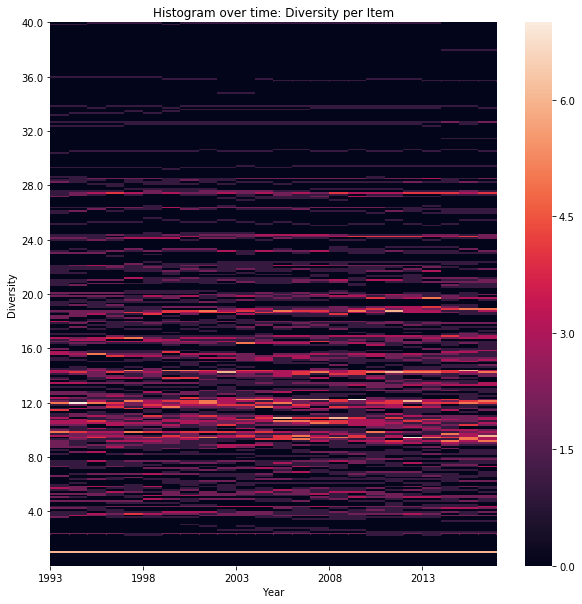

In [313]:
hist_time(dfdiv,"Diversity per Item")

Looking at how the distribution (histogram) of diveristy changes over time, no major change is seen. Overall items seem to be traded in similar ways over time.

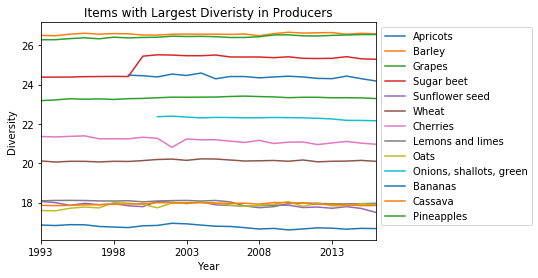

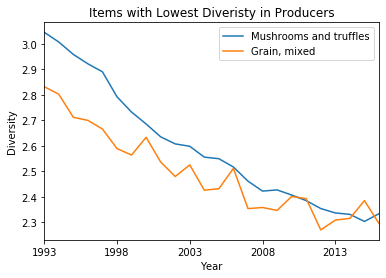

In [297]:
div_mean = dfdiv.mean(axis=1).mean()
div_std = 1.1*dfdiv.mean(axis=1).std()

df_u = dfdiv[dfdiv.mean(axis=1)>(div_mean+div_std)]
df_u.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Items with Largest Diveristy in Producers")
plt.show()

df_l = dfdiv[(dfdiv.mean(axis=1)<(div_mean-div_std))&(dfdiv.mean(axis=1)>1)]
df_l.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Items with Lowest Diveristy in Producers")
plt.show()

# Diversity of Crops per Country

The same diversity metric is use to analyze how diverse are the crops that each individual country produces.

In [298]:
#Select cutoffs to test
    #The total quantity (sum accross year) is calculated
    #Cutoff removes any total_quantity that is smaller than the max total_quanity for each item
cutoff_n = 11
cutoff_l = 0
cutoff_u = 0.4
cutoffs = np.linspace(cutoff_l,cutoff_u,cutoff_n)

#Initialize dataframes
dfdiv_list = list()
dfent_list = list()
df_mm = pd.DataFrame()
df_pos_l = pd.DataFrame()


#Compute diversity for each cutoff, for each country, for each year
for i in range(cutoff_n):
    cutoff = cutoffs[i]
    
    #Intialize diversity and entropy dataframe
    dfdiv=pd.DataFrame()
    dfent=pd.DataFrame()
    
    for country in df_prod.Area.unique():
        
        #Select country
        df_t = df_prod[df_prod["Area"]==country] 
        
        #Filter by cutoff
        filt = df_t.loc[:,"Y1993":].sum(axis=1)>(max(df_t.loc[:,"Y1993":].sum(axis=1))*cutoff) 
        df_t = df_t[filt]
        df_t = df_t.loc[:,"Y1993":] #Select only number values

        divsr = []
        entsr = []
        
        #For each year
        for col in df_t:
        
            #Calculate diversity values
            pv = df_t[col]/df_t[col].values.sum()
            ent = pv*np.log2(pv)*-1
            div = np.exp(ent)
            
            #Store diversity and entropy values in list
            if div.sum()>0:
                divsr.append(div.sum())
            else:
                divsr.append(np.NaN)
                
            if ent.sum()>0:
                entsr.append(ent.sum())
            else:
                entsr.append(np.NaN)
                
        #Store list of divropy values in dataframe
        dfdiv[country] = divsr
        dfent[country] = entsr
    
    #Transpose dataframe for viewing purposes
    dfdiv = dfdiv.transpose()
    dfent = dfent.transpose()
    
    #Store dataframe for each cutoff in list
    dfdiv_list.append(dfdiv)
    dfent_list.append(dfent)
    
    #Caluclate order (position of min_max) for later selection
    df_pos = dfdiv.idxmax(axis=1)-dfdiv.idxmin(axis=1)
    df_pos_l[str(i)] = df_pos/np.abs(df_pos)

    #Calculate min max difference for later selection
    df_mm[str(i)] = dfdiv.max(axis=1)-dfdiv.min(axis=1)



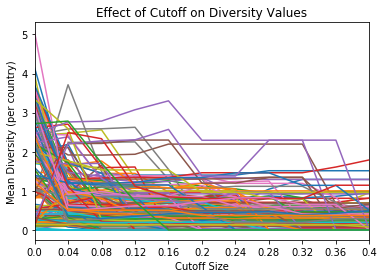

In [299]:
#Plot effect of cutoff on min_max value for each item (diversity)
df_mm.transpose().plot(legend=False)
plt.xticks(range(cutoff_n),cutoffs.round(2))
plt.xlabel("Cutoff Size")
plt.ylabel("Mean Diversity (per country)")
plt.title("Effect of Cutoff on Diversity Values")
plt.show()

Again, 0.08 serves as a satisfying cutoff

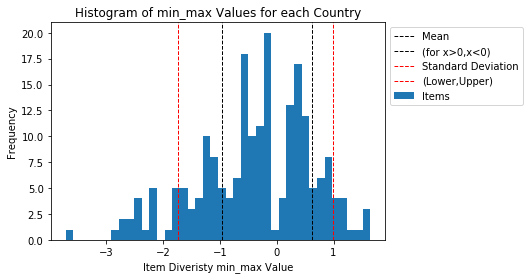

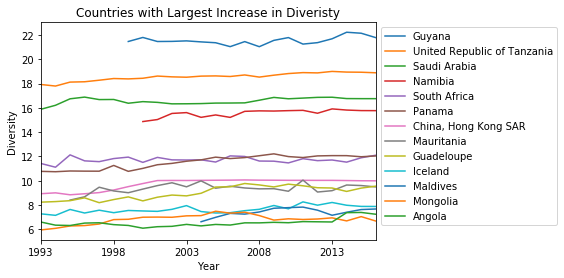

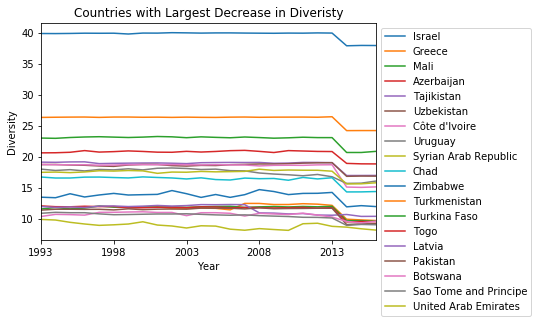

In [334]:
#Select specific cutoff to plot
cutoff = 0.04
ind_df = [i for i, x in enumerate(cutoffs==cutoff) if x][0]

#Select dataframes to plot
df_mv = df_mm[str(ind_df)].copy()
df_pos = df_pos_l[str(ind_df)]
dfdiv = dfdiv_list[ind_df]


#Generate histogram of min_max values
df_mv = (df_mv*df_pos)
df_mv.plot.hist(bins=40)
plt.xlabel("Item Diveristy min_max Value")


#Plot means for positive and negative min_max
plt.axvline(df_mv[df_mv<0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(df_mv[df_mv>0].mean(), color='k', linestyle='dashed', linewidth=1)

#Identify item selection thresholds (1 std) for largest and smallest min_max
thresh_u = df_mv[df_mv>0].mean()+df_mv[df_mv>0].std()
thresh_l = df_mv[df_mv<0].mean()-df_mv[df_mv<0].std()
#Plot these thresholds on the histogram
plt.axvline(thresh_u, color='r', linestyle='dashed', linewidth=1)
plt.axvline(thresh_l, color='r', linestyle='dashed', linewidth=1)
plt.legend(["Mean","(for x>0,x<0)","Standard Deviation","(Lower,Upper)","Items"], bbox_to_anchor=(1, 1))
plt.title("Histogram of min_max Values for each Country")
plt.show()

#Generate diversity plots for selected min_max items
df_u = dfdiv.loc[df_mv[(df_mv>thresh_u)].index.values,:]
df_u = df_u.assign(m=df_u.mean(axis=1)).sort_values('m',ascending=False).drop('m', axis=1)
df_u.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Countries with Largest Increase in Diveristy")
plt.show()


df_l = dfdiv.loc[df_mv[(df_mv<thresh_l)].index.values,:]
df_l = df_l.assign(m=df_l.mean(axis=1)).sort_values('m',ascending=False).drop('m', axis=1)
df_l.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Countries with Largest Decrease in Diveristy")
plt.show()

No country has had a large increase in crop diveristy. Note these drops in diversity are due to a loss of "Cottonseed" as a category. This is probably due to a naming convention in FAO.




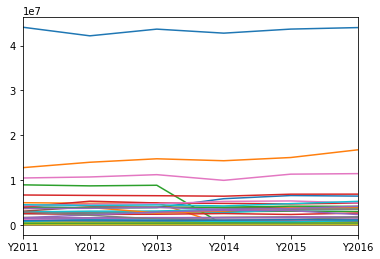

Item
Cottonseed    8848497.0
dtype: float64


,Area,Item,Element,Unit,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
1862,Azerbaijan,Cottonseed,Production,tonnes,164000.0,170000.0,146500.0,145000.0,75000.0,68864.0,...,66000.0,36600.0,21100.0,25200.0,43800.0,42000.0,43000.0,0.0,0.0,0.0
4025,Botswana,Cottonseed,Production,tonnes,1368.0,1384.0,1549.0,1947.0,1600.0,1470.0,...,1256.0,1445.0,798.0,756.0,585.0,590.0,590.0,0.0,0.0,0.0
4778,Burkina Faso,Cottonseed,Production,tonnes,53000.0,105000.0,78000.0,105000.0,195570.0,184997.0,...,190000.0,315000.0,265000.0,328000.0,274000.0,376000.0,430000.0,0.0,0.0,0.0
5876,Chad,Cottonseed,Production,tonnes,60000.0,80000.0,90000.0,120433.0,146086.0,86140.0,...,55000.0,56000.0,30000.0,35000.0,50000.0,55000.0,53000.0,0.0,0.0,0.0
8199,Côte d'Ivoire,Cottonseed,Production,tonnes,123658.0,133384.0,114000.0,112651.0,142776.0,179273.0,...,190000.0,65850.0,70000.0,91000.0,170000.0,180000.0,207000.0,0.0,0.0,0.0
13493,Greece,Cottonseed,Production,tonnes,454000.0,574000.0,725000.0,540000.0,590000.0,665000.0,...,500000.0,502000.0,449000.0,390000.0,490000.0,425000.0,507000.0,0.0,0.0,0.0
16603,Israel,Cottonseed,Production,tonnes,46750.0,55100.0,70418.0,96475.0,86100.0,81300.0,...,29000.0,14000.0,11700.0,11000.0,25500.0,23460.0,16950.0,0.0,0.0,0.0
20641,Mali,Cottonseed,Production,tonnes,140000.0,164000.0,210904.0,239584.0,239336.0,230000.0,...,151000.0,124000.0,144000.0,159000.0,299000.0,333000.0,449646.0,0.0,0.0,0.0
24612,Pakistan,Cottonseed,Production,tonnes,2735420.0,2958579.0,3604172.0,3188915.0,3124146.0,2990250.0,...,3694900.0,3760000.0,4138200.0,3664600.0,4293300.0,4149100.0,4071366.0,0.0,0.0,0.0
31698,Syrian Arab Republic,Cottonseed,Production,tonnes,406691.0,335000.0,372062.0,471196.0,649360.0,635200.0,...,387000.0,402300.0,423838.0,307115.0,436584.0,385224.0,409945.0,0.0,0.0,0.0


In [350]:
df_pl = df_prod[df_prod["Area"].isin(df_l.index)]

df_pli = df_pl.set_index("Item")
df_pli = df_pli.loc[:,"Y2011":].groupby("Item").sum()

df_pli.transpose().plot(legend=False)
plt.show()

pli_dif = df_pli.loc[:,"Y2013"]-df_pli.loc[:,"Y2014"]
print(pli_dif[pli_dif == pli_dif.max()])
df_pl[df_pl["Item"]=="Cottonseed"]

When looking at diveristy per Hectare (land use) Uruguay has the most significatn drop in doversity

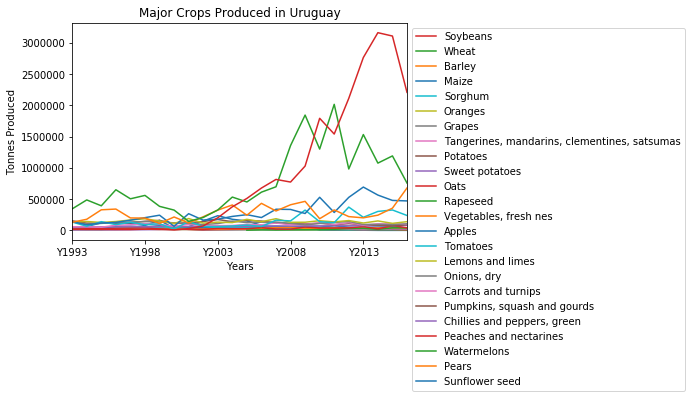

In [309]:
df_uruguay = df_prod[df_prod["Area"]=="Uruguay"].set_index("Item").loc[:,"Y1993":]
df_uruguay = df_uruguay[df_uruguay.mean(axis=1)>10000]
ax = df_uruguay.sort_values(by=["Y2016"]).transpose().plot()
handles, labels = ax.get_legend_handles_labels()
plt.xlabel("Years")
plt.ylabel("Tonnes Produced")
plt.title("Major Crops Produced in Uruguay")
ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1, 1))

Uruguay seems to have drastically increased its production of soy and wheat since 2004.

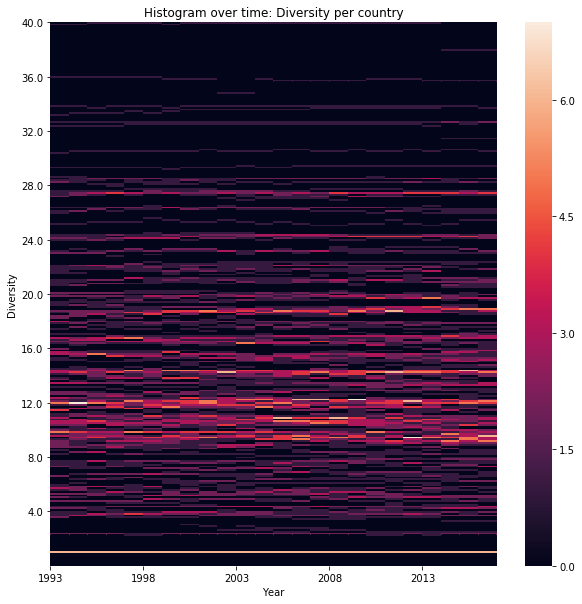

In [314]:
hist_time(dfdiv,"Diversity per country")

Overall crop production diversity drops, due to the group of coutries mentioned above ('Cottonseed Artefact')

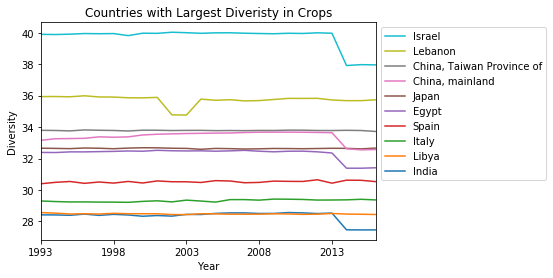

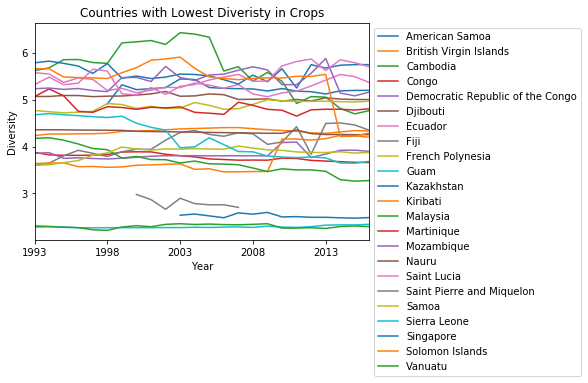

In [311]:
div_mean = dfdiv.mean(axis=1).mean()
div_std = 1.1*dfdiv.mean(axis=1).std()

df_u = dfdiv[dfdiv.mean(axis=1)>(div_mean+div_std)]
ax = df_u.assign(m=df_u.mean(axis=1)).sort_values('m').drop('m', axis=1).tail(10).transpose().plot()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Countries with Largest Diveristy in Crops")
plt.show()

df_l = dfdiv[(dfdiv.mean(axis=1)<(div_mean-div_std))&(dfdiv.mean(axis=1)>1)]
df_l.transpose().plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks([0,5,10,15,20],[1993,1998,2003,2008,2013])
plt.xlabel("Year")
plt.ylabel("Diversity")
plt.title("Countries with Lowest Diveristy in Crops")
plt.show()

No significant trend is seen among the countries with most diverse and least diverse crop production.